In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torchvision

from model import Discriminator, Generator
from preprocess import get_images, get_mask
from torchsummary import summary
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
n_epochs = 10
alpha = 0.02
learning_rate = 0.001
batch_size = 32

In [15]:
train_loader, test_loader = get_images(batch_size)
image_size = (32, 32)
square_size = 16
binary_mask = get_mask(image_size, square_size)
# reshape binary mask to add batch_size dimension
binary_mask = binary_mask.unsqueeze(0)
binary_mask = binary_mask.expand(batch_size, -1, -1)
binary_mask = binary_mask.to(device)

print(binary_mask.shape)

Files already downloaded and verified
torch.Size([32, 32, 32])


In [17]:
generator = Generator().to(device)
summary(generator, [(3, 32, 32), (32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           3,232
            Conv2d-2           [-1, 32, 32, 32]           3,232
           Sigmoid-3           [-1, 32, 32, 32]               0
         LeakyReLU-4           [-1, 32, 32, 32]               0
         LeakyReLU-5           [-1, 32, 32, 32]               0
         LeakyReLU-6           [-1, 32, 32, 32]               0
         LeakyReLU-7           [-1, 32, 32, 32]               0
         LeakyReLU-8           [-1, 32, 32, 32]               0
         LeakyReLU-9           [-1, 32, 32, 32]               0
        LeakyReLU-10           [-1, 32, 32, 32]               0
        LeakyReLU-11           [-1, 32, 32, 32]               0
        LeakyReLU-12           [-1, 32, 32, 32]               0
        LeakyReLU-13           [-1, 32, 32, 32]               0
        LeakyReLU-14           [-1, 32,

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [18]:
discriminator = Discriminator().to(device)
summary(discriminator, [(3, 32, 32), (32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           6,464
         LeakyReLU-2           [-1, 64, 16, 16]               0
  SpectralNormConv-3           [-1, 64, 16, 16]               0
            Conv2d-4            [-1, 128, 8, 8]         204,928
         LeakyReLU-5            [-1, 128, 8, 8]               0
  SpectralNormConv-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]         819,456
         LeakyReLU-8            [-1, 256, 4, 4]               0
  SpectralNormConv-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]       1,638,656
        LeakyReLU-11            [-1, 256, 2, 2]               0
 SpectralNormConv-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 256, 1, 1]       1,638,656
        LeakyReLU-14            [-1, 25

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [19]:
learning_rate_gen = 0.0001
learning_rate_dis = 0.0004

opt_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate_gen)
opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_dis)

In [20]:
for epoch in range(n_epochs):
    #Training
    train_loss = 0
    loss = 0
    discriminator.train()
    generator.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)

        ### TRAIN THE DISCRIMINATOR ###
        # clear the gradients of all optimized variables for discriminator
        opt_discriminator.zero_grad()
        # model forward
        x_fake, x_coarse, x_refinement = generator(data, binary_mask)
        x_all = torch.cat([x_fake, data], dim=0)
        masks_double = torch.cat([binary_mask, binary_mask], dim=0)
        x_hat_all = discriminator(x_all, masks_double)
        # compute the discriminator loss
        loss_dis = discriminator.loss_function(x_hat_all[:batch_size], x_hat_all[batch_size:])
        # backward/update discriminator
        loss_dis.backward()
        opt_discriminator.step()
        
        ### TRAIN THE GENERATOR ###
        # clear the gradients of all optimized variables for generator
        opt_generator.zero_grad()
        # model forward
        x_fake, x_coarse, x_refinement = generator(data, binary_mask)
        x_hat_dis = discriminator(x_fake, binary_mask)
        # compute the generator loss
        loss_gen = generator.loss_function(x_hat_dis)
        loss_recon = generator.combined_rec_loss_function(data, x_coarse, x_refinement, binary_mask, 1/40)
        loss_gen += loss_recon
        # backward/update generator
        loss_gen.backward()
        opt_generator.step()

        # update running training loss
        train_loss += loss_gen + loss_dis
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Epoch: 0 	Training Loss: 2.082877
Epoch: 1 	Training Loss: 2.054574
Epoch: 2 	Training Loss: 2.044731
Epoch: 3 	Training Loss: 2.028241
Epoch: 4 	Training Loss: 2.026617
Epoch: 5 	Training Loss: 2.025422
Epoch: 6 	Training Loss: 2.024161
Epoch: 7 	Training Loss: 2.022795
Epoch: 8 	Training Loss: 2.012156
Epoch: 9 	Training Loss: 2.016068


In [24]:
#Testing
test_loss = count = 0
loss = 0
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        if data.shape[0] != batch_size:
            continue
        data = data.to(device)
        binary_mask = binary_mask.to(device)
        # model forward
        x_fake, x_coarse, x_refinement = generator(data, binary_mask)
        x_all = torch.cat([x_fake, data], dim=0)
        masks_double = torch.cat([binary_mask, binary_mask], dim=0)
        x_hat_all = discriminator(x_all, masks_double)
        # compute the discriminator loss
        loss_dis = discriminator.loss_function(x_hat_all[:batch_size], x_hat_all[batch_size:])
        x_hat_dis = discriminator(x_fake, binary_mask)
        # compute the loss
        loss_dis = discriminator.loss_function(x_hat_all[:batch_size], x_hat_all[batch_size:])
        loss_gen = generator.loss_function(x_fake)
        # update running training loss
        test_loss += (loss_gen + loss_dis)

    test_loss = test_loss / len(test_loader)
    print('Test Loss: {:.6f}'.format(test_loss))

Test Loss: 1.520080


In [25]:
# val_loss = count = 0
# torch.cuda.empty_cache()
# inpaint.eval()
# input = None
# output = None

# with torch.no_grad():
#     for batch_idx, (data, _) in enumerate(test_loader):
#         if data.shape[0] != batch_size:
#             continue
#         data = data.to(device)
#         binary_mask = binary_mask.to(device)
#         x_hat = inpaint(data, binary_mask)
#         loss = inpaint.loss_function(x_hat, data, binary_mask, alpha)
#         val_loss += loss
#         count += 1

#         input = data
#         output = x_hat
    
# val_loss = val_loss / count
# print(f'Validation loss: {val_loss:.4f}')


In [28]:
# B x C x H x W
input = data[:5]
output = x_fake[:5]

# B x H x W x C
input = input.permute(0, 2, 3, 1)
output = output.permute(0, 2, 3, 1)

input = input.cpu()
output = output.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


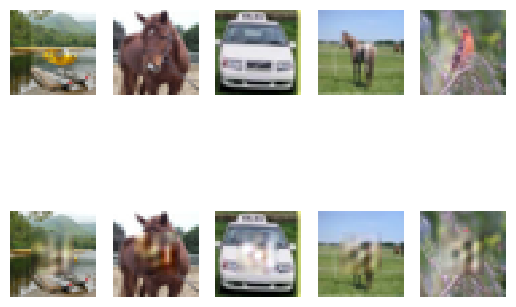

In [29]:
f, axarr = plt.subplots(2,5)
axarr[0, 0].axis("off")
axarr[0, 0].imshow(input[0], interpolation='nearest')
axarr[0, 1].axis("off")
axarr[0, 1].imshow(input[1], interpolation='nearest')
axarr[0, 2].axis("off")
axarr[0, 2].imshow(input[2], interpolation='nearest')
axarr[0, 3].axis("off")
axarr[0, 3].imshow(input[3], interpolation='nearest')
axarr[0, 4].axis("off")
axarr[0, 4].imshow(input[4], interpolation='nearest')

axarr[1, 0].axis("off")
axarr[1, 0].imshow(output[0], interpolation='nearest')
axarr[1, 1].axis("off")
axarr[1, 1].imshow(output[1], interpolation='nearest')
axarr[1, 2].axis("off")
axarr[1, 2].imshow(output[2], interpolation='nearest')
axarr[1, 3].axis("off")
axarr[1, 3].imshow(output[3], interpolation='nearest')
axarr[1, 4].axis("off")
axarr[1, 4].imshow(output[4], interpolation='nearest')